In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *

from redTools import *
from Kcorrect import *

In [2]:
########################################################
def getReddening_err(table, band1='r', band2='w2'):
    
    pc0  = table['P0_w2']
    P1W2p = table['P0_w2p']
    R_source = table['R_source']
    indx, = np.where(R_source==0)
    pc0[indx] = P1W2p[indx]
    
    Epc0 = table['P0_w2_e']
    inc  = table['inc']   
    Einc = table['inc_e']
    
    if band1=='w2':
        a,b,c,d, alpha, beta, theta, Ealpha, Ebeta = getReddening_params(band1='w1', band2=band2)
        gamma = (a*pc0**3+b*pc0**2+c*pc0+d)
        d_gamma = np.abs((3*a*pc0**2+2*b*pc0+c)*Epc0)
        gamma = gamma/3.107
        d_gamma = gamma/3.107
    else:
        a,b,c,d, alpha, beta, theta, Ealpha, Ebeta = getReddening_params(band1=band1, band2=band2)
        gamma = (a*pc0**3+b*pc0**2+c*pc0+d)
        d_gamma = np.abs((3*a*pc0**2+2*b*pc0+c)*Epc0)
    
    indx, = np.where(gamma<0)
    gamma[indx]=0
    d_gamma[indx]=0

    q2 = 10**(-1.*theta)
    F = log_a_b(inc, q2)
    dF2 = Elogab2(inc, q2, Einc)
    dM2 = dF2*(a*pc0**3+b*pc0**2+c*pc0+d)**2+(F*(3*a*pc0**2+2*b*pc0+c)*Epc0)**2
    
    Aj_e2 = np.sqrt(dM2)
    Aj = F*gamma
    
    return Aj_e2
########################################################

### table must be dictionary

def plot_array(table, cluster, reject=[], weird=[], clusterName='Coma Cluster', nest='Nest_100001', 
               xLim = (1.5,2.9), yLim = (19.5,6.5), isVirgo=False):
    
#     cluster = 'NEST_100001.csv'   # Coma
    ctl   = np.genfromtxt(cluster , delimiter='|', filling_values=-1, names=True, dtype=None, encoding=None)
    PGC = ctl['PGC']
    
    dye = {"u":"blue","g":"green","r":"red","i":"orange","z":"maroon","w1":"purple", 'w2': "brown"}
    fig = py.figure(figsize=(4, 18), dpi=100) 
    fig.subplots_adjust(wspace=0, top=0.95, bottom=0.15, left=0.05, right=0.98)
    gs = gridspec.GridSpec(7, 1) ; p=0
    
    band_lst = ['u', 'g','r','i','z','w1','w2']
    
    for band in band_lst:
        
        xlabel = False; ylabel=True
        if band=='w2': xlabel=True
        
        ax = plt.subplot(gs[p]) ; p+=1
        
        try: 
            plot_band(ax, table, PGC, reject=reject, weird=weird, color=dye[band], 
                  xlabel=xlabel, ylabel=ylabel, band=band, xLim=xLim, yLim=yLim, isVirgo=isVirgo)
        except:
            p-=1
            pass
        
        yticks = ax.yaxis.get_major_ticks()
#         if band!='w2': yticks[-1].label1.set_visible(False)
        if band!='w2': plt.setp(ax.get_xticklabels(), visible=False)   
        if band=='u': ax.set_title(nest+' ... '+clusterName, fontsize=14)
    
    
    plt.subplots_adjust(hspace=.0, wspace=0)
    

def linfit(x, m, b):
    return m * x + b
def linfit_b(x, m):
    return m * x
def linfit_m(x, b):
    return x+b


def plot_band(ax, table, PGC, reject=[], weird=[], color='red', 
              xlabel=True, ylabel=True, X_twin=True, Y_twin=True, band='r', 
              xLim = (1.5,2.9), yLim = (19.5,6.5), isVirgo=False):  
    
    pgc       = table['pgc']
    logWimx   = table['logWimx']
    logWimx_e = table['logWimx_e']
    Vhel      = table['Vhel']
    
    Aj_e2     = getReddening_err(table, band1=band, band2='w2')
    
    mag = table[band+'_sss']
    mag_e = np.sqrt((mag*0.+0.05)**2+Aj_e2**2)
    
    pgc_ = []
    logWimx_ = []
    logWimx_e_ = []
    mag_ = []
    mag_e_ = []
    Sqlt_ = []
    Wqlt_ = []
    
    for i, idd in enumerate(pgc):
        if idd in PGC and not idd in reject:
            if isVirgo:
                if Vhel[i]<600 or (Vhel[i]>1200 and Vhel[i]<1600):
                    if mag[i]>5 and mag[i]<20:
                        pgc_.append(idd)
                        logWimx_.append(logWimx[i])
                        logWimx_e_.append(logWimx_e[i])
                        mag_.append(mag[i])
                        mag_e_.append(mag_e[i])
                        Sqlt_.append(table['Sqlt'][i])
                        Wqlt_.append(table['Wqlt'][i])
            else:
                 if mag[i]>5 and mag[i]<20:
                    pgc_.append(idd)
                    logWimx_.append(logWimx[i])
                    logWimx_e_.append(logWimx_e[i])
                    mag_.append(mag[i])
                    mag_e_.append(mag_e[i])
                    Sqlt_.append(table['Sqlt'][i])
                    Wqlt_.append(table['Wqlt'][i])                
            
            
            
    pgc_=np.asarray(pgc_)
    logWimx_=np.asarray(logWimx_)
    logWimx_e_=np.asarray(logWimx_e_)
    mag_=np.asarray(mag_)
    mag_e_=np.asarray(mag_e_)
    Sqlt_=np.asarray(Sqlt_)
    Wqlt_=np.asarray(Wqlt_)
    N = len(pgc_)
    
    dofit = np.zeros(N)
      
    for i in range(N):
        
        if pgc_[i] in weird:  ### open circle symbols
                ax.errorbar(logWimx_[i], mag_[i], xerr=logWimx_e_[i], yerr=mag_e_[i], fmt='o', 
                            color='k', markersize=3, markerfacecolor='white')   
        else:
            if not band in ['w1','w2'] and Sqlt_[i]>=2:
                ax.errorbar(logWimx_[i], mag_[i], xerr=logWimx_e_[i], yerr=mag_e_[i], fmt='o', 
                            color=color, markersize=4, alpha=0.7)
                dofit[i]=1
            elif band in ['w1','w2'] and Wqlt_[i]>=2:
                ax.errorbar(logWimx_[i], mag_[i], xerr=logWimx_e_[i], yerr=mag_e_[i], fmt='o', 
                            color=color, markersize=4, alpha=0.7)
                dofit[i]=1
            else:
                ax.errorbar(logWimx_[i], mag_[i], xerr=logWimx_e_[i], yerr=mag_e_[i], fmt='o', 
                            color='k', markersize=3, markerfacecolor='white')   

    ax.tick_params(which='major', length=6, width=1.5, direction='in')
    ax.tick_params(which='minor', length=4, color='#000033', width=1.5, direction='in')
    ax.minorticks_on()
    ax.set_xlim(xLim)        
    ax.set_ylim(yLim)
    
    
    indx, = np.where(dofit==1)
    pgc_ = pgc_[indx]
    logWimx_= logWimx_[indx]
    logWimx_e_= logWimx_e_[indx]
    mag_= mag_[indx]
    mag_e_= mag_e_[indx]
    
    ### 'Virgo W cluster' condition
    if band in ['u', 'g']:
        indx = np.asarray([int(i) for i, idd in enumerate(pgc_) if not idd in [39886, 39114]])
        logWimx_= logWimx_[indx]
        logWimx_e_= logWimx_e_[indx]
        mag_= mag_[indx]
        mag_e_= mag_e_[indx]            
    
    
#     print band
#     for i, moog in enumerate(logWimx_):
#         print mag_[i], mag_e_[i], moog, logWimx_e_[i]
    
## Traditional one way linear fit      
    fit, cov = curve_fit(linfit, mag_, logWimx_-2.5, sigma=np.sqrt(logWimx_e_**2+0.01**2))
    m, b = fit
    me = np.sqrt(cov[0,0])
    be = np.sqrt(cov[1,1])
    mbe = cov[1,0]

#     b_, cov_b = curve_fit(linfit_m, m*mag_, logWimx_-2.5, sigma=logWimx_e_)
#     be_ = np.sqrt(cov_b[0])
#     m_, cov_m = curve_fit(linfit_b, mag_, logWimx_-2.5-b, sigma=logWimx_e_)
#     me_ = np.sqrt(cov_m[0])    

    y = np.linspace(5,20,50)
    x = m*y+b+2.5
    ax.plot(x,y, 'k--')  
    m0 = 1./m
    b0 = -b/m
    dm0 = np.abs(me/m**2)
    db0 = np.sqrt((b0**2 )*(be**2/b**2+me**2/m**2-2*mbe/m/b))
    
#     db0 = np.sqrt((me_*b)**2+(be_*m)**2)/m**2   ## Treating m and b like independent variables
    
    
    Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
    x0 = 0.95*Xlm[0]+0.05*Xlm[1]
    y0 = 0.15*Ylm[0]+0.85*Ylm[1]
    ax.text(x0,y0, "Slope = "+"%.2f" % m0+'$\pm$'+"%.2f" % dm0, fontsize=12, color='k')
    y0 = 0.30*Ylm[0]+0.70*Ylm[1]
    ax.text(x0,y0, "ZP = "+"%.2f" % b0+'$\pm$'+"%.2f" % db0, fontsize=12, color='k')     
    

#### Linear MCMC fit, considering all errors in both directions
    y_ = np.linspace(5,20,50)
    M,B,samples=linMC1D(mag_, logWimx_-2.5, np.sqrt(logWimx_e_**2+0.01**2), nsteps=1000, ignore=200)
    m = M[0] ; me=0.5*(M[1]+M[2])
    b = B[0] ; be=0.5*(B[1]+B[2])
    m0 = 1./m
    b0 = -b/m
    dm0 = np.abs(me/m**2)
    db0 = np.sqrt((me*b)**2+(be*m)**2)/m**2
    x_, xu, xl = linSimul(samples, y_, size=500)
    ax.fill_betweenx(y_, x_+5*xu+2.50, x_-5*xl+2.50, color='k', alpha=0.2, edgecolor="none")
#     ax.plot(m*y_+b+2.5, y_, 'r--') 
#     Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
#     x0 = 0.9*Xlm[0]+0.1*Xlm[1]
#     y0 = 0.22*Ylm[0]+0.78*Ylm[1]
#     ax.text(x0,y0, "m= "+"%.2f" % m0+'$\pm$'+"%.2f" % dm0, fontsize=12, color='red')
#     y0 = 0.40*Ylm[0]+0.60*Ylm[1]
#     ax.text(x0,y0, "b= "+"%.2f" % b0+'$\pm$'+"%.2f" % db0, fontsize=12, color='red')      


#     fit, cov = np.polyfit(mag_,logWimx_-2.5, 1, w=1./logWimx_e_, cov=True, full = False)
#     m, b = fit
#     y = np.linspace(5,20,50)
#     x = m*y+b+2.5
#     ax.plot(x,y, 'r--')  
#     m0 = 1./m
#     b0 = -b/m   
    
    fit, cov = curve_fit(linfit, mag_, logWimx_-2.5)
#     fit, cov = np.polyfit(mag_,logWimx_-2.5, 1, cov=True, full = False)
    m, b = fit
    y = np.linspace(5,20,50)
    x = m*y+b+2.5
    ax.plot(x,y, 'b--')  
    m0 = 1./m
    b0 = -b/m      
    
   
    if ylabel: 
        if not band in ['w1','w2']:
            ax.set_ylabel(r'$'+band+'^*$', fontsize=18) 
        else:
            ax.set_ylabel(r'$'+band.upper()+'^*$', fontsize=18)
    
    if xlabel:
        ax.set_xlabel(r'$Log( W_{mx}^i)$', fontsize=18) 
    
    if True:
        y_ax = ax.twinx()
        y_ax.set_ylim(yLim)
        y_ax.set_yticklabels([])
        y_ax.minorticks_on()
        y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        
    
    if True:
        x_ax = ax.twiny()
        x_ax.set_xlim(xLim)
        x_ax.set_xticklabels([])
        x_ax.minorticks_on()
        x_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')     

        
    for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
    for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
      

In [3]:
table   = np.genfromtxt('corrected_mags_linewidth_all.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)
pgc = table['pgc']

print len(pgc)

10659


In [4]:
for idd in [2816236]:
    if not idd in pgc:
        print idd

2816236


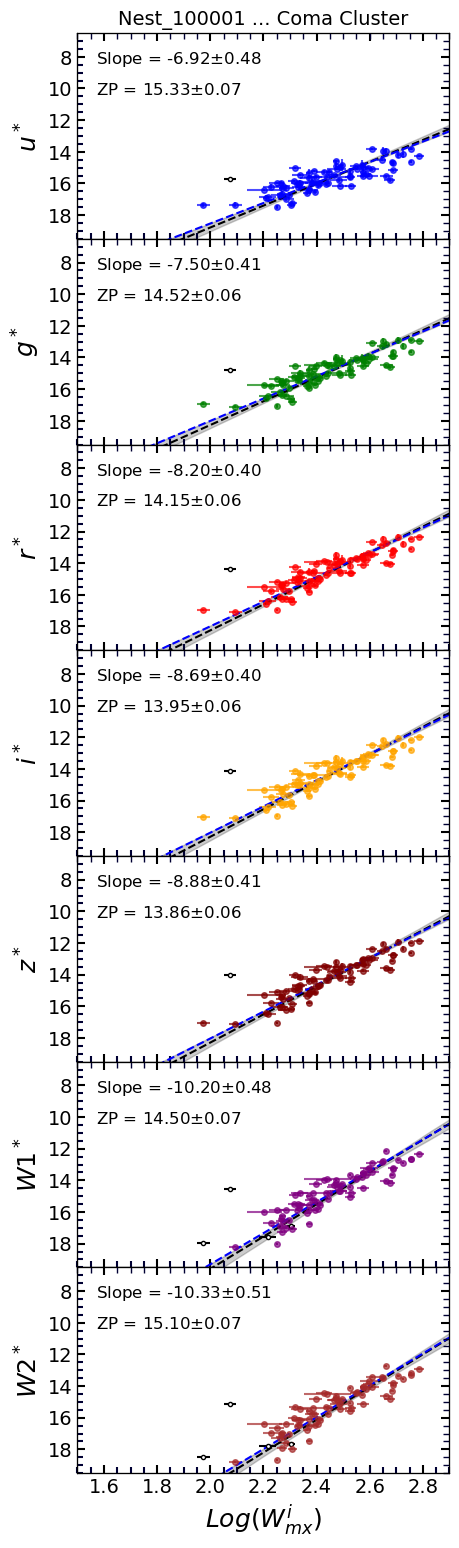

In [5]:
reject = [43164,44405,93666]
weird = [43511]
plot_array(table, 'NEST_100001.csv', reject=reject, weird=weird, 
           clusterName='Coma Cluster', nest='Nest_100001')

# reject = []
# weird = [41440]
# plot_array(table, 'NEST_100002.csv', reject=reject, weird=weird, 
#            clusterName='Virgo Cluster', nest='Nest_100002', isVirgo=True)

### SOUTH
# reject = []
# weird = []
# plot_array(table, 'NEST_100003.csv', reject=reject, weird=weird, 
#            clusterName='Centaurus Cluster', nest='Nest_100003')

# reject = [36323,36328,36330,36608,200155]
# weird = [37140]
# plot_array(table, 'NEST_100005.csv', reject=reject, weird=weird, 
#            clusterName='Abell 1367', nest='Nest_100005')


# reject = []
# weird = []
# plot_array(table, 'NEST_100006.csv', reject=reject, weird=weird, 
#            clusterName='Hydra Cluster', nest='Nest_100006')

# reject = [56977,2790835]
# weird = []
# plot_array(table, 'NEST_100007.csv', reject=reject, weird=weird, 
#            clusterName='Abell 2151 (Hercules)', nest='Nest_100007')

# reject = [37550]
# weird = []
# plot_array(table, 'NEST_100008.csv', reject=reject, weird=weird, 
#            clusterName='Ursa Major', nest='Nest_100008')


# reject = []
# weird = []
# plot_array(table, 'NEST_100014.csv', reject=reject, weird=weird, 
#            clusterName='Antila Cluster', nest='Nest_100014')


# reject = [38333]
# weird = []
# plot_array(table, 'NEST_100018.csv', reject=reject, weird=weird, 
#            clusterName='NGC4065 cluster', nest='Nest_100018')


# reject = [23308]
# weird = []
# plot_array(table, 'NEST_100030.csv', reject=reject, weird=weird, 
#            clusterName='Cancer cluster', nest='Nest_100030')

# reject = [] 
# weird = []
# plot_array(table, 'NEST_120002.csv', reject=reject, weird=weird, 
#            clusterName='Virgo W cluster', nest='Nest_120002')

# reject = [3446,4020] 
# weird = [1904373]
# plot_array(table, 'NEST_200005.csv', reject=reject, weird=weird, 
#            clusterName='NGC410 cluster', nest='Nest_200005')

# reject = [4740,4876,5008] 
# weird = []
# plot_array(table, 'NEST_200006.csv', reject=reject, weird=weird, 
#            clusterName='NGC507 cluster', nest='Nest_200006')


# reject = [11150,11199,138562,3647754] 
# weird = []
# plot_array(table, 'NEST_200012.csv', reject=reject, weird=weird, 
#            clusterName='Abell 400 cluster', nest='Nest_200012')


# reject = [85526,85643,90431,197699] 
# weird = [5057398]
# plot_array(table, 'NEST_200016.csv', reject=reject, weird=weird, 
#            clusterName='Abell 2634/66 cluster', nest='Nest_200016')

# reject = [] 
# weird = []
# plot_array(table, 'NEST_200017.csv', reject=reject, weird=weird, 
#            clusterName='Abell 539 cluster', nest='Nest_200017')

# reject = [1724] 
# weird = []
# plot_array(table, 'NEST_200037.csv', reject=reject, weird=weird, 
#            clusterName='NGC70 cluster', nest='Nest_200037')

## PGC 2816236 is next to a bright star so I removed it
# reject = [90474] 
# weird = [1707532]
# plot_array(table, 'NEST_200045.csv', reject=reject, weird=weird, 
#            clusterName='NGC80 cluster', nest='Nest_200045')

# reject = [70712, 70998, 71360] 
# weird = []
# plot_array(table, 'NEST_200092.csv', reject=reject, weird=weird, 
#            clusterName='Pegasus cluster', nest='Nest_200092')
